## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Reading the dataset

In [4]:
df = pd.read_csv("fpl_data.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (476, 13)


,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
0,Alex Runnarsson,Arsenal,Goalkeeper,0,0,1,15,0,0.0,16.6,0,0,0
1,Alexandre Lacazette,Arsenal,Forward,13,3,129,1916,21,307.4,602.4,797,21,7
2,Bernd Leno,Arsenal,Goalkeeper,0,0,131,3131,37,0.0,702.2,2,11,11
3,Bukayo Saka,Arsenal,Midfielder,5,5,114,2554,31,650.6,493.0,984,8,8
4,Calum Chambers,Arsenal,Defender,0,3,36,751,10,169.4,171.8,77,3,2


### Understanding the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player_Name     476 non-null    object 
 1   Club            476 non-null    object 
 2   Position        476 non-null    object 
 3   Goals_Scored    476 non-null    int64  
 4   Assists         476 non-null    int64  
 5   Total_Points    476 non-null    int64  
 6   Minutes         476 non-null    int64  
 7   Goals_Conceded  476 non-null    int64  
 8   Creativity      476 non-null    float64
 9   Influence       476 non-null    float64
 10  Threat          476 non-null    int64  
 11  Bonus           476 non-null    int64  
 12  Clean_Sheets    476 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 48.5+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Goals_Scored,476.0,1.907563,3.455562,0.0,0.00,0.50,2.00,23.0
Assists,476.0,1.752101,2.708563,0.0,0.00,0.00,2.00,14.0
Total_Points,476.0,58.516807,51.293559,0.0,10.00,48.00,94.25,244.0
Minutes,476.0,1336.909664,1073.773995,0.0,268.75,1269.50,2256.25,3420.0
Goals_Conceded,476.0,19.157563,15.946171,0.0,4.00,18.00,31.00,68.0
Creativity,476.0,195.976050,251.478541,0.0,8.30,96.95,296.95,1414.9
Influence,476.0,294.617647,267.779681,0.0,46.50,233.10,499.50,1318.2
Threat,476.0,224.962185,318.240377,0.0,5.75,104.50,298.25,1980.0
Bonus,476.0,4.718487,6.252625,0.0,0.00,2.00,7.00,40.0
Clean_Sheets,476.0,4.745798,4.394312,0.0,0.00,4.00,8.00,19.0


In [7]:
df.duplicated().sum()

np.int64(0)

## Scaling the data before clustering

In [8]:
scaler = StandardScaler()
subset = df.iloc[:, 3:].copy()  # Data with numerical features
subset_scaled = scaler.fit_transform(subset)
data = pd.DataFrame(subset_scaled, columns = subset.columns)

## PCA

In [9]:
n = subset.shape[1]
pca = PCA(n_components = n, random_state = 1)
pca.fit(data)

explained_var = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_
cumulative = np.cumsum(explained_var_ratio)

     PC  ExplainedVariance  ExplainedVarianceRatio  CumulativeVarianceRatio
0   PC1             7.2301                  0.7215                   0.7215
1   PC2             1.3688                  0.1366                   0.8581
2   PC3             0.5892                  0.0588                   0.9169
3   PC4             0.3145                  0.0314                   0.9483
4   PC5             0.2279                  0.0227                   0.9710
5   PC6             0.1526                  0.0152                   0.9862
6   PC7             0.0702                  0.0070                   0.9932
7   PC8             0.0395                  0.0039                   0.9972
8   PC9             0.0195                  0.0019                   0.9991
9  PC10             0.0087                  0.0009                   1.0000


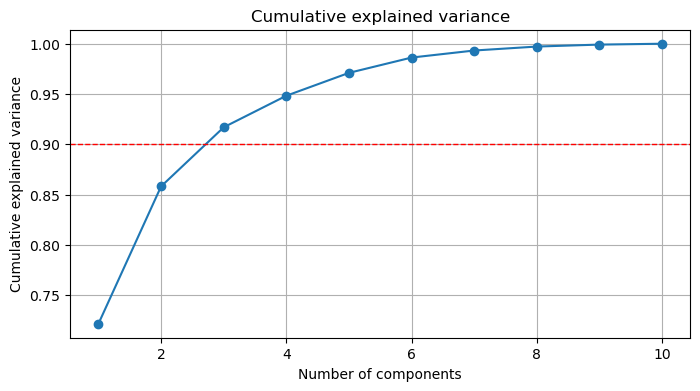

In [10]:
ev_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_var_ratio))],
    "ExplainedVariance": explained_var,
    "ExplainedVarianceRatio": explained_var_ratio,
    "CumulativeVarianceRatio": cumulative
})
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print(ev_df)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative)+1), cumulative, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.axhline(0.90, color="r", linestyle="--", linewidth=1)  # 90% guideline
plt.title("Cumulative explained variance")
plt.grid(True)
plt.show()

## Creating PCA-transformed dataset for clustering

In [11]:
n_components = 3

pca = PCA(n_components=n_components, random_state=42)
data_pca = pca.fit_transform(data)
print("PCA shape:", data_pca.shape)

PCA shape: (476, 3)


## Finding optimal k using inertia and silhouette score

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

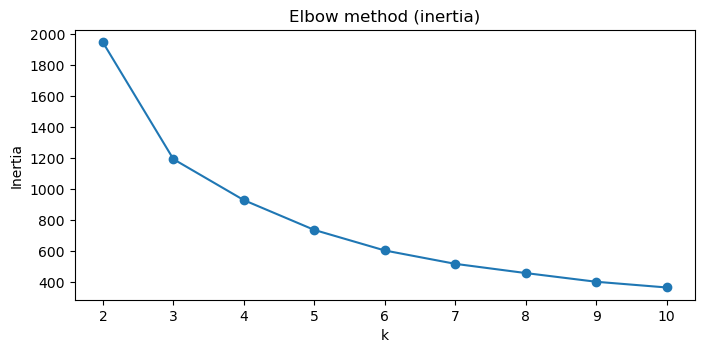

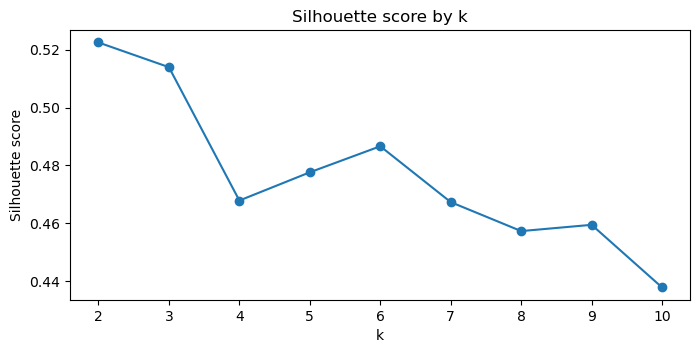

In [12]:
k_range = range(2, 11)
inertias = []
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(data_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(data_pca, labels))

# Plot inertia (elbow)
plt.figure(figsize=(8,3.5))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method (inertia)")
plt.xticks(k_range)
plt.show()

# Plot silhouette
plt.figure(figsize=(8,3.5))
plt.plot(k_range, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score by k")
plt.xticks(k_range)
plt.show()

## KMeans Clustering

In [13]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(data_pca)
df["Cluster"] = labels

# Cluster centers in PCA space and approximate centers back in original feature space
centers_pca = kmeans.cluster_centers_
centers_original_approx = scaler.inverse_transform(pca.inverse_transform(centers_pca))
centers_df = pd.DataFrame(centers_original_approx, columns=data.columns)
print("Approx cluster centers (original feature scale):")
display(centers_df.round(3))

Approx cluster centers (original feature scale):


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
0,8.7870,6.8340,142.5250,2492.4590,33.4350,615.2840,663.3900,867.8780,15.5130,9.6300
1,0.3560,0.3720,17.6200,461.8750,7.1190,51.9250,78.4770,65.1550,0.6580,1.3550
2,1.6060,1.8770,87.4870,2200.3670,31.6520,251.1820,476.2690,218.7490,6.6640,7.9380


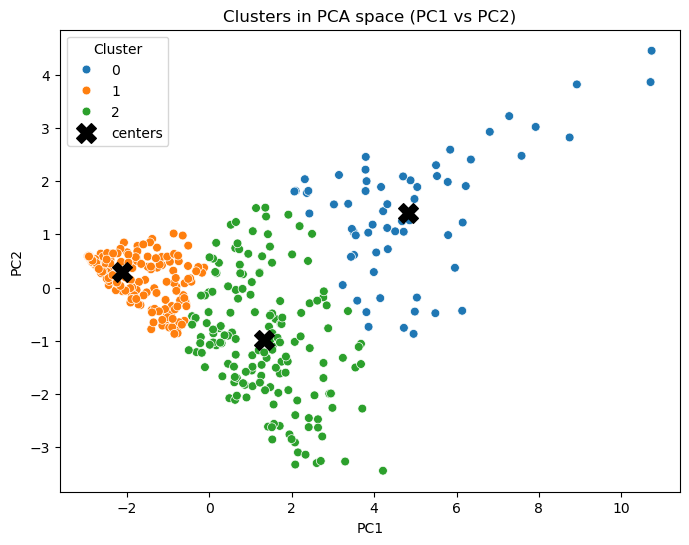

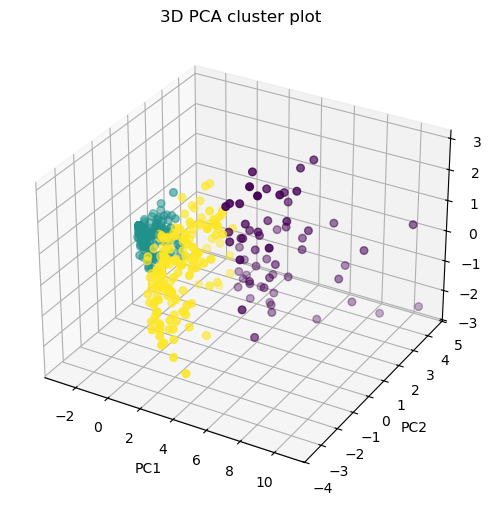

In [14]:
# 2D scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=labels, palette="tab10", s=40, legend="full")
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", marker="X", s=200, label="centers")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Clusters in PCA space (PC1 vs PC2)")
plt.legend(title="Cluster")
plt.show()

# 3D plot
if data_pca.shape[1] >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data_pca[:,0], data_pca[:,1], data_pca[:,2], c=labels, s=30)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    plt.title("3D PCA cluster plot")
    plt.show()


In [15]:
# Profiling: counts & descriptive stats on original numeric features
cluster_counts = df["Cluster"].value_counts().sort_index()
cluster_props = (cluster_counts / len(df)).round(3)
print("Counts per cluster:\n", cluster_counts)
print("Proportions:\n", cluster_props)

# Detailed profile: mean/median/std for numeric features by cluster
profile = df.groupby("Cluster")[data.columns].agg(["mean","median","std"]).round(3)
display(profile)

# Top differentiating features per cluster (relative to global mean)
global_mean = df.iloc[:,3:].mean()
cluster_means = df.groupby("Cluster")[data.columns].mean()
delta_pct = ((cluster_means - global_mean) / global_mean.replace(0, np.nan)).fillna(0)
top_features = {c: delta_pct.loc[c].sort_values(ascending=False).head(5).index.tolist()
                for c in delta_pct.index}
print("Top 5 positively different features per cluster (vs global mean):")
for c, feats in top_features.items():
    print(f" Cluster {c}: {feats}")

Counts per cluster:
 Cluster
0     63
1    248
2    165
Name: count, dtype: int64
Proportions:
 Cluster
0   0.1320
1   0.5210
2   0.3470
Name: count, dtype: float64


Goals_Scored               Assists               Total_Points  \
                mean median    std    mean median    std         mean   
Cluster                                                                 
0             8.7300 9.0000 4.8900  6.7620 6.0000 3.3200     142.1110   
1             0.3470 0.0000 0.7260  0.4030 0.0000 0.7890      17.9480   
2             1.6480 1.0000 1.7660  1.8670 1.0000 1.9330      87.5760   

                           Minutes  ... Influence   Threat                    \
          median     std      mean  ...       std     mean   median      std   
Cluster                             ...                                        
0       135.0000 32.5310 2476.0630  ...  187.1280 850.6510 814.0000 395.2640   
1        11.5000 17.7800  455.8510  ...   85.5830  59.1530  15.0000  89.3270   
2        83.0000 26.8570 2226.2180  ...  171.8780 235.2790 200.0000 173.7290   

          Bonus                Clean_Sheets                 
           mean  median    std         mean  median    std  
Cluster                                                     
0       16.2540 16.0000 6.1280       9.4290 10.0000 2.9110  
1        0.8550  0.0000 1.5700       1.3350  0.0000 1.7210  
2        6.1210  5.0000 4.4340       8.0850  8.0000 3.3210  

[3 rows x 30 columns]

Top 5 positively different features per cluster (vs global mean):
 Cluster 0: ['Goals_Scored', 'Assists', 'Threat', 'Bonus', 'Creativity']
 Cluster 1: ['Cluster', 'Goals_Conceded', 'Minutes', 'Total_Points', 'Clean_Sheets']
 Cluster 2: ['Clean_Sheets', 'Minutes', 'Goals_Conceded', 'Influence', 'Total_Points']


* **Cluster 0: The Attacking Dynamo**
    * **Description:** Players defined by offensive metrics like goals, assists, threat, and creativity.
    * **Player Type:** Forwards and attacking midfielders.

* **Cluster 1: The Workhorse Defender**
    * **Description:** Players with high total points and minutes, but also a mixed defensive record (high clean sheets and goals conceded).
    * **Player Type:** Starting defenders and goalkeepers.

* **Cluster 2: The Influential Defender**
    * **Description:** Players with high defensive influence, in addition to consistent playing time and defensive stats.
    * **Player Type:** Central defenders and full-backs.